## Setup Mario

In [1]:
! pip install -q nes-py gym-super-mario-bros==7.3.0

In [3]:
import gym_super_mario_bros #import the game
import matplotlib.pyplot as plt

from nes_py.wrappers import JoypadSpace #import the JoyPad wrapper
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT #import the simplified controls

In [6]:
print (len(SIMPLE_MOVEMENT))
SIMPLE_MOVEMENT

7


[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [20]:
env=gym_super_mario_bros.make("SuperMarioBros-v0")

In [21]:
print(env.action_space)
print(env.action_space.sample())
# print(env.observation_space)

Discrete(256)
91


In [22]:
env=gym_super_mario_bros.make("SuperMarioBros-v0")
env=JoypadSpace(env, SIMPLE_MOVEMENT) #wrapping the environment in JoyPad and reduce the actions that can be taken

Discrete(7)
2
(240, 256, 3)


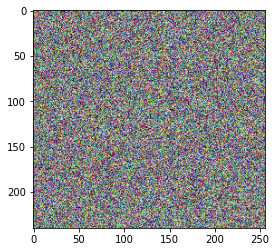

In [33]:
print(env.action_space) #went from 256 actions available to 7 actions
print(env.action_space.sample())
# print(env.observation_space)
print(env.observation_space.sample().shape)
plt.imshow(env.observation_space.sample()) #???

In [34]:
for episode in range(1):
    done=False
    env.reset()
    
    while not done:
        env.render()
        state, reward, done, info=env.step(env.action_space.sample())

env.close()

/Users/elizabeth/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [35]:
env.close()

ValueError: env has already been closed.

## Preprocess Environment

In [37]:
!pip install -q torch torchvision torchaudio

In [39]:
!pip install -q "stable-baselines3[extra]"

In [4]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

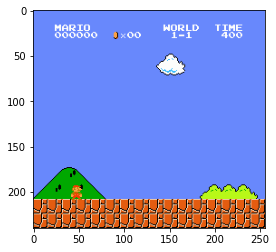

In [5]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state=env.reset()
state,reward, done,info=env.step(5)
plt.imshow(state)

In [6]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True) # with keep_dim=True, shape(240,256)>(240,256,1)
env = DummyVecEnv([lambda:env])
env = VecFrameStack(env, 4, channels_order="last")

In [82]:
state=env.reset()
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])# action 5 is jumping

In [87]:
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])
state,reward, done, info=env.step([5])

In [55]:
state.shape

(1, 240, 256, 4)

In [59]:
state[0].shape

(240, 256, 4)

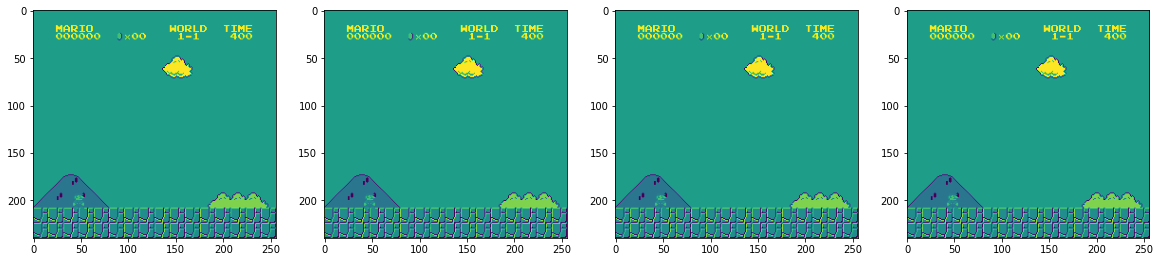

In [61]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]): #state.shape[3] = 4 (I stacked 4 frames) 0,1,2,3
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,1])
plt.show() # idk why Mario is not jumping :/

In [63]:
env.close()

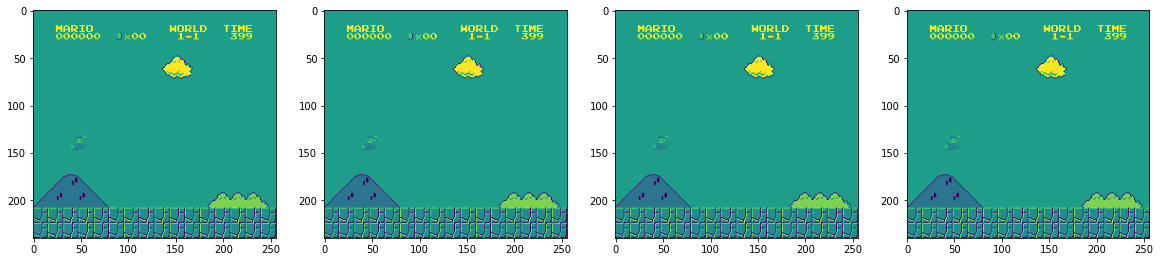

In [89]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]): #state.shape[3] = 4 (I stacked 4 frames) 0,1,2,3
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,1])
plt.show() #have to run env.step function a bunch of times before Mario starts jumping

In [90]:
env.close()

## Train RL Model

In [7]:
import os

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [9]:
checkpoint_dir="./train/"
log_dir="./logs/"

In [10]:
callback=TrainAndLoggingCallback(check_freq=1000,save_path=checkpoint_dir)

In [11]:
model=PPO("CnnPolicy",env,verbose=1,tensorboard_log=log_dir,learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [11]:
model.learn(total_timesteps=3000,callback=callback)

Logging to ./logs/PPO_1


/Users/elizabeth/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 37  |
|    iterations      | 1   |
|    time_elapsed    | 13  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 18            |
|    iterations           | 2             |
|    time_elapsed         | 56            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.7353795e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00943      |
|    learning_rate        | 1e-06         |
|    loss                 | 139           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000289     |
|    value_loss           | 275           |
-------------------------------------------
-----

In [13]:
! tensorboard --logdir .

^C


In [14]:
model.save("finalmodel")

## Test Model

In [12]:
model=model.load("./train/best_model_3000")

In [13]:
for game in range(2):
    done=False
    obs=env.reset()
    reward=[]
    while not done:
        action,_=model.predict(obs)
        obs, reward, done, info=env.step(action)
        env.render()
    print(sum(reward)) #needs to train for at least 4 mil steps

/Users/elizabeth/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-15.0
-15.0


In [15]:
env.close()

In [14]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True) # with keep_dim=True, shape(240,256)>(240,256,1)
env = DummyVecEnv([lambda:env])
env = VecFrameStack(env, 4, channels_order="last")

obs=env.reset()

print(model.predict(obs)) # returns 2 values

(array([1]), None)


To improve the model furthermore:
- Train for longer time with slower learning rate
- Try multiprocessing (AI playing multiple game at the same time)
- Try different algorithms